## Flux Disorder MC Integrator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Parámetros
NMCS = 10**8   # Número de muestras (puedes aumentar o disminuir según tus recursos)
NBINS = 50
kas = [6, 3, 2.5]
a = [None]*3
y = [None]*3
v = [None]*3
s = [None]*3


for i in range(0,3):  
    # Generación de datos Monte Carlo usando vectorización
    rng = np.random.default_rng()

    # a: half-width of the Poiseuille tube = 1.8*rand() + 0.1  => valores en [0.1, 1.9)
    a[i] = (1.0 - 1.0/kas[i])/((1.0 - rng.random(NMCS))**(1.0/kas[i]))
    
    # y: transverse coordinate, uniformemente en [-a, a]
    y[i] = (2.0 * rng.random(NMCS) - 1.0) * a[i]
   
    # v: Eulerian velocity, con alpha = 1.0 => v = a^2 - y^2
    v[i] = a[i]**2 - y[i]**2

    # s: shear = 2*|y|
    s[i] = 2.0 * np.abs(y[i])
    

# Pesos: vector de unos (efectivamente histogramas sin ponderar)
weights = np.ones(NMCS)


/home/jose/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Cálculo de histogramas 1D

In [3]:
def compute_histogram(data, nbins, min_val, max_val):
    hist, bin_edges = np.histogram(data, bins=nbins, range=(min_val, max_val), weights=weights)
    bin_width = (max_val - min_val) / nbins
    density = hist / (weights.sum() * bin_width)
    # Calculamos el centro de cada bin
    bin_centers = bin_edges[:-1] + bin_width/2
    return density, bin_centers

# Histogramas para cada variable:
min_a1 = min_a2 = min_a3 = min_v1 = min_v2 = min_v3 = min_s1 = min_s2 = min_s3 = 0.0
max_a1 = max_a2 = max_a3 = max_v1 = max_v2 = max_v3 = max_s1 = max_s2 = max_s3 = max_y1 = max_y2 = max_y3= 3.0
min_y1 = min_y2 = min_y3 = -3.0
 
histo_a1, bins_a1 = compute_histogram(a[0], NBINS, min_a1, max_a1)
histo_y1, bins_y1 = compute_histogram(y[0], NBINS, min_y1, max_y1)
histo_v1, bins_v1 = compute_histogram(v[0], NBINS, min_v1, max_v1 )
histo_s1, bins_s1 = compute_histogram(s[0], NBINS, min_s1, max_s1)

histo_a2, bins_a2 = compute_histogram(a[1], NBINS, min_a2, max_a2)
histo_y2, bins_y2 = compute_histogram(y[1], NBINS, min_y2, max_y2)
histo_v2, bins_v2 = compute_histogram(v[1], NBINS, min_v2, max_v2)
histo_s2, bins_s2 = compute_histogram(s[1], NBINS, min_s2, max_s2)

histo_a3, bins_a3 = compute_histogram(a[2], NBINS, min_a3, max_a3)
histo_y3, bins_y3 = compute_histogram(y[2], NBINS, min_y3, max_y3)
histo_v3, bins_v3 = compute_histogram(v[2], NBINS, min_v3, max_v3)
histo_s3, bins_s3 = compute_histogram(s[2], NBINS, min_s3, max_s3)

### Cálculo del histograma 2D logarítmico 

Se definen los límites para v y s en la escala logarítmica. Se crean los bordes de los bins geométricos con `np.geomspace` y se calculan tres histogramas 2D:

- **H**: Conteo (usando los pesos) en cada bin.
- **H_true**: Suma ponderada de s para cada bin.
- **H_err**: Suma ponderada de s² para cada bin (para estimar error).

Luego se normaliza cada celda del histograma 2D dividiendo por un factor dependiente del bin (similar a la normalización en el código C original) y se calculan los promedios condicionados.

In [4]:
# Definición de límites para los bins en la escala logarítmica:

min1 = [None]*3
max1 = [None]*3
min2 = [None]*3
max2 = [None]*3

v_bins = [None]*3
s_bins = [None]*3
H = [None]*3
H_err = [None]*3
H_true = [None]*3
shear_given_v = [None]*3
sh_error_given_v = [None]*3
v_centers = [None]*3
s_centers = [None]*3

for i in range(0,3):
    min1[i] = 1.0e-3  # límite inferior para v (para evitar log(0))
    max1[i] = 100.0
    min2[i] = 1.0e-4  # límite inferior para s
    max2[i] = 100.0

    v_bins[i] = np.geomspace(min1[i], max1[i], NBINS+1)
    s_bins[i] = np.geomspace(min2[i], max2[i], NBINS+1)

    # Cálculo del histograma 2D (usando np.histogram2d)
    H[i], _, _ = np.histogram2d(v[i], s[i], bins=[v_bins[i], s_bins[i]], weights=weights)
    H_true[i], _, _ = np.histogram2d(v[i], s[i], bins=[v_bins[i], s_bins[i]], weights=s[i] * weights)
    H_err[i],  _, _ = np.histogram2d(v[i], s[i], bins=[v_bins[i], s_bins[i]], weights=(s[i]**2) * weights)

    # Normalización del histograma 2D
    # Se define: v_ratio = exp(log(max1/min1)/NBINS) y s_ratio análogamente.
    v_ratio = np.exp(np.log(max1[i]/min1[i]) / NBINS)
    s_ratio = np.exp(np.log(max2[i]/min2[i]) / NBINS)
    H_norm = H[i].copy()
    row_sums = H[i].sum(axis=1)

    for k in range(NBINS):
        row_sum = row_sums[k]
        if row_sum != 0:
            # v_i: límite inferior del bin i para v
            v_i = min1[i] * (v_ratio ** k)
            for j in range(NBINS):
                # s_j: límite inferior del bin j para s
                s_j = min2[i] * (s_ratio ** j)
                H_norm[k, j] /= (row_sum * v_i*(v_ratio-1) * s_j*(s_ratio-1))

    # Cálculo del shear condicionado a v (promedio y error)
    shear_given_v[i] = np.zeros(NBINS)
    sh_error_given_v[i] = np.zeros(NBINS)
    for k in range(NBINS):
        row_sum = row_sums[k]
        if row_sum != 0:
            row_mean = H_true[i][k, :].sum() / row_sum
            row_mean2 = H_err[i][k, :].sum() / row_sum
            shear_given_v[i][k] = row_mean
            sh_error_given_v[i][k] = np.sqrt(max(0, (row_mean2 - row_mean**2) / row_sum))

    # Se calculan los centros de cada bin (geométricos) para v y s:
    v_centers[i] = np.sqrt(v_bins[i][:-1] * v_bins[i][1:])
    s_centers[i] = np.sqrt(s_bins[i][:-1] * s_bins[i][1:])

### Visualización de los histogramas 1D

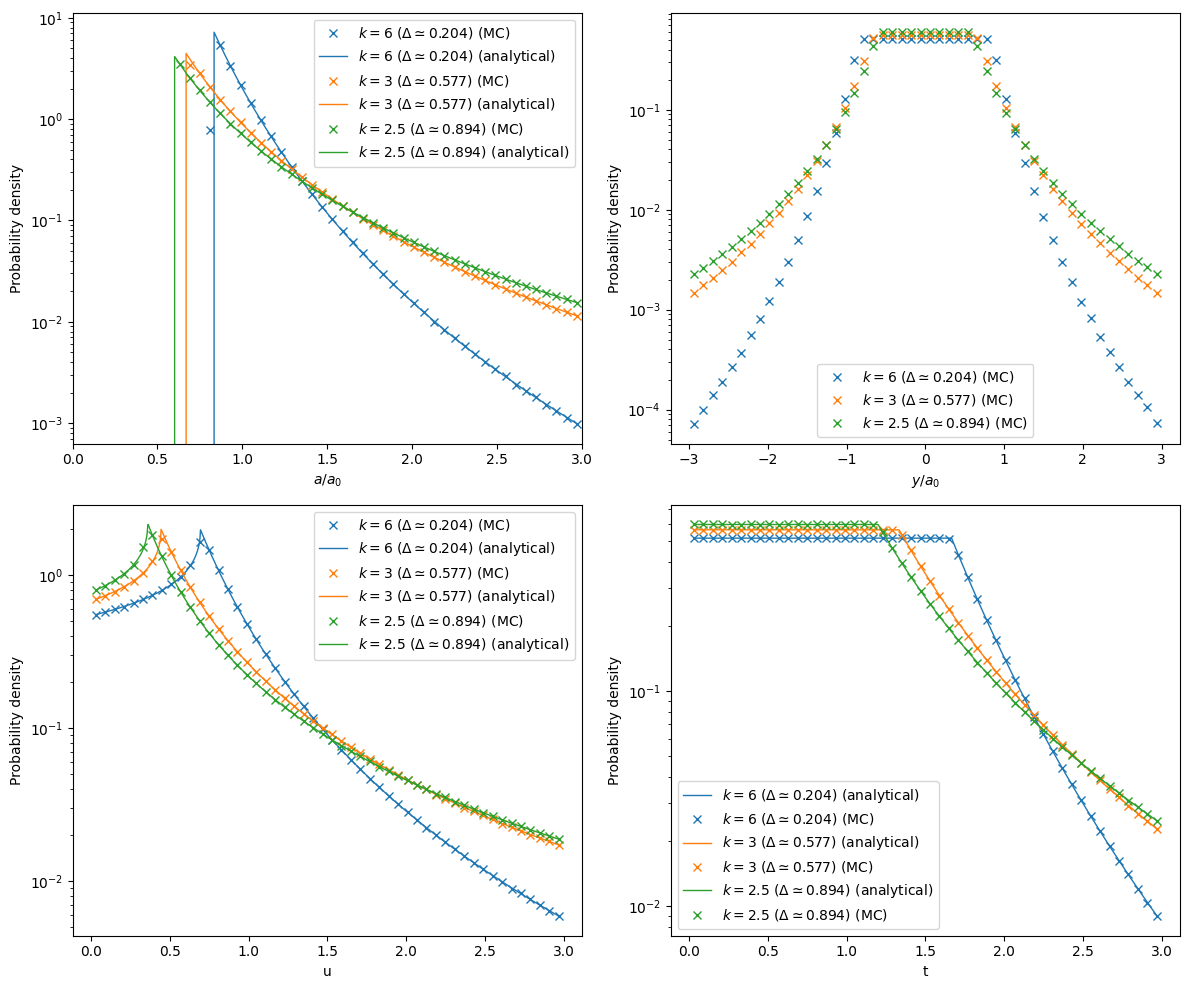

In [5]:
import mpmath as mp

# Funciones analíticas para cada subplot

def analytical_a(a_range, k):
    a_min = 1.0 - 1.0/k
    return np.heaviside(a_range - a_min, 0) * (k * (a_min**k) / (a_range**(k+1)))

def analytical_u_value(vi, k):
    a_min = 1.0 - 1.0/k
    term1 = k * a_min**k * (1/vi)**((k+2)/2) * mp.sqrt(mp.pi) * mp.gamma((k+2)/2) / (4 * mp.gamma((k+3)/2))
    term2 = k * a_min**k * (1/vi)**((k+2)/2) * 0.5 * ( mp.sqrt(a_min**2/vi - 1.0) * 
                                                      mp.hyp2f1(0.5, (k+3)/2, 1.5, -(a_min**2/vi - 1.0)) )
    return float(mp.re((term1 - term2)*np.heaviside(a_min**2 - vi, 0) + term1*np.heaviside(vi - a_min**2, 0)))

def analytical_u(v_range, k):
    """Vectoriza la función analítica para u."""
    return np.array([analytical_u_value(vi, k) for vi in v_range])

def analytical_t(s_range, k):
    a_min = 1.0 - 1.0/k
    return (k/((k+1)*2*a_min)) * np.heaviside(2*a_min - s_range, 1) \
           + (k/((k+1)*2*a_min)) * ((2*a_min)/s_range)**(k+1) * np.heaviside(s_range - 2*a_min, 0)

# Datos comunes: se definen colores y etiquetas para cada k
plot_data = [
    {'k': kas[0], 'color': '#1f77b4', 'mc_label': r'$k = 6$ ($\Delta \simeq 0.204$) (MC)', 'an_label': r'$k = 6$ ($\Delta \simeq 0.204$) (analytical)'},
    {'k': kas[1], 'color': '#ff7f0e', 'mc_label': r'$k = 3$ ($\Delta \simeq 0.577$) (MC)', 'an_label': r'$k = 3$ ($\Delta \simeq 0.577$) (analytical)'},
    {'k': kas[2], 'color': '#2ca02c', 'mc_label': r'$k = 2.5$ ($\Delta \simeq 0.894$) (MC)', 'an_label': r'$k = 2.5$ ($\Delta \simeq 0.894$) (analytical)'}
]

# Se asume que los bins y histogramas están en listas ordenadas por índice:
bins_a_list = [bins_a1, bins_a2, bins_a3]
histo_a_list = [histo_a1, histo_a2, histo_a3]
bins_y_list = [bins_y1, bins_y2, bins_y3]
histo_y_list = [histo_y1, histo_y2, histo_y3]
bins_v_list = [bins_v1, bins_v2, bins_v3]
histo_v_list = [histo_v1, histo_v2, histo_v3]
bins_s_list = [bins_s1, bins_s2, bins_s3]
histo_s_list = [histo_s1, histo_s2, histo_s3]

plt.figure(figsize=(12, 10))

# Subplot 1: Histogram for a/a₀ (MC y analítico)
plt.subplot(2,2,1)
for i, data in enumerate(plot_data):
    k_val, col = data['k'], data['color']
    bins = bins_a_list[i]
    histo = histo_a_list[i]
    # Datos MC
    plt.plot(bins, histo, linestyle='', marker='x', markersize=6, color=col, label=data['mc_label'])
    # Curva analítica
    a_range = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(a_range, analytical_a(a_range, k_val), '-', color=col, linewidth=1, label=data['an_label'])
plt.xlabel(r'$a/a_{0}$')
plt.ylabel('Probability density')
plt.yscale('log')
plt.xlim(0, 3)
plt.legend()

# Subplot 2: Histogram for y/a₀ (solo MC)
plt.subplot(2,2,2)
for i, data in enumerate(plot_data):
    plt.plot(bins_y_list[i], histo_y_list[i], linestyle='', marker='x', markersize=6, color=data['color'], label=data['mc_label'])
plt.xlabel(r'$y/a_{0}$')
plt.ylabel('Probability density')
plt.yscale('log')
plt.legend()

# Subplot 3: Histogram for u (MC y analítico)
plt.subplot(2,2,3)
for i, data in enumerate(plot_data):
    k_val, col = data['k'], data['color']
    bins = bins_v_list[i]
    histo = histo_v_list[i]
    # Datos MC
    plt.plot(bins, histo, linestyle='', marker='x', markersize=6, color=col, label=data['mc_label'])
    # Curva analítica con mpmath (evaluada punto a punto)
    v_range = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(v_range, analytical_u(v_range, k_val), '-', color=col, linewidth=1, label=data['an_label'])
plt.xlabel('u')
plt.ylabel('Probability density')
plt.yscale('log')
plt.legend()

# Subplot 4: Histogram for t (MC y analítico)
plt.subplot(2,2,4)
for i, data in enumerate(plot_data):
    k_val, col = data['k'], data['color']
    bins = bins_s_list[i]
    histo = histo_s_list[i]
    # Curva analítica
    s_range = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(s_range, analytical_t(s_range, k_val), '-', color=col, linewidth=1, label=data['an_label'])
    # Datos MC
    plt.plot(bins, histo, linestyle='', marker='x', markersize=6, color=col, label=data['mc_label'])
plt.xlabel('t')
plt.ylabel('Probability density')
plt.yscale('log')
plt.legend()

plt.tight_layout()
fig = plt.gcf()
plt.draw()
renderer = fig.canvas.get_renderer()
for i, ax in enumerate(fig.get_axes(), start=1):
    bbox_inches = ax.get_tightbbox(renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"subplot_{i}.pdf", bbox_inches=bbox_inches, dpi=300)

plt.savefig("plot_total.pdf", dpi=300)
plt.show()



### Visualización del histograma 2D normalizado (v vs s)

Se utiliza `pcolormesh` para graficar la matriz del histograma normalizado en escala logarítmica en ambos ejes.

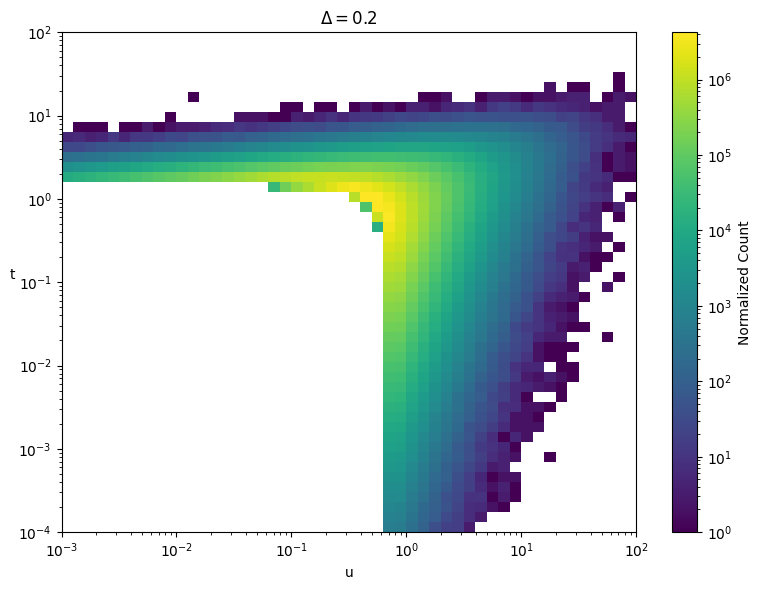

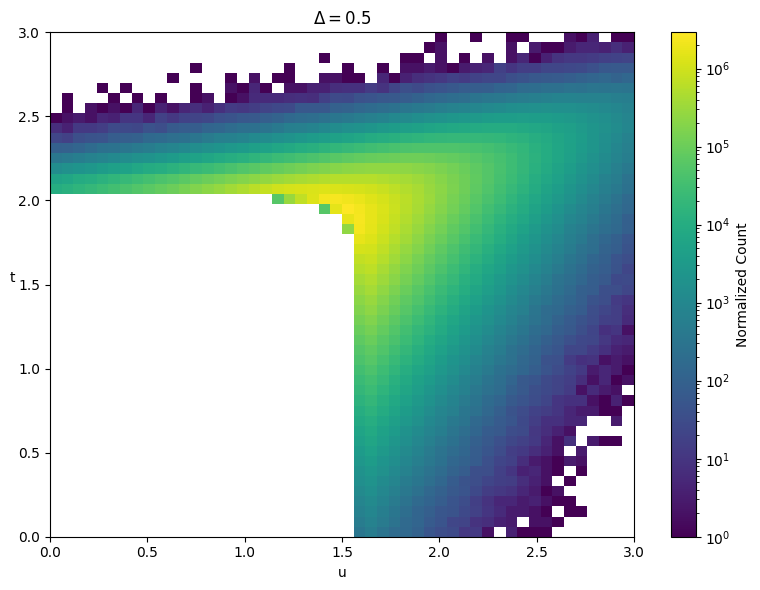

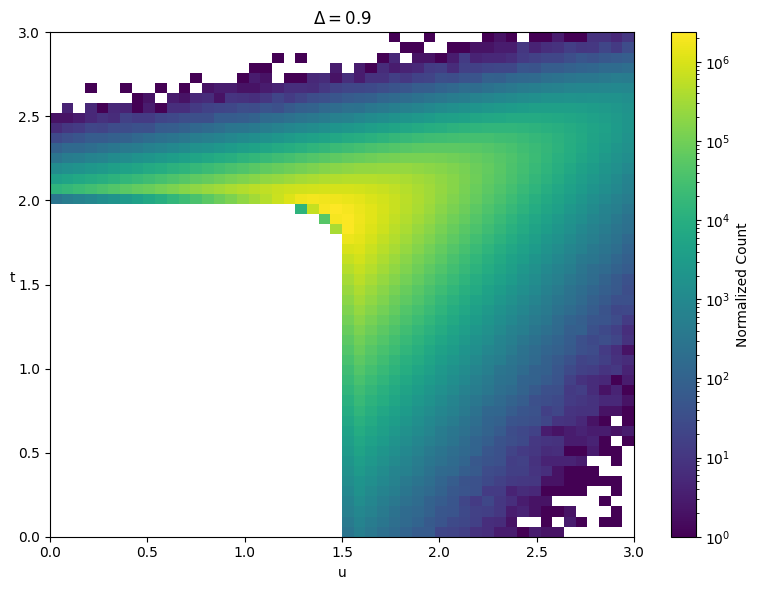

In [6]:
plt.figure(figsize=(8,6))
H_norm = H[0].copy()
plt.pcolormesh(v_bins[0], s_bins[0], H_norm.T, shading='auto', cmap='viridis', norm=mcolors.LogNorm())
plt.xlabel('u')
plt.ylabel('t', rotation=0)
plt.title('$\Delta = 0.2$')
cbar = plt.colorbar()
cbar.set_label('Normalized Count')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
H_norm = H[1].copy()
plt.pcolormesh(bins_v2, bins_s2, H_norm.T, shading='auto', cmap='viridis', norm=mcolors.LogNorm())
plt.xlabel('u')
plt.ylabel('t', rotation=0)
plt.title('$\Delta = 0.5$')
cbar = plt.colorbar()
cbar.set_label('Normalized Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
H_norm = H[2].copy()
plt.pcolormesh(bins_v3, bins_s3, H_norm.T, shading='auto', cmap='viridis', norm=mcolors.LogNorm())
plt.xlabel('u')
plt.ylabel('t', rotation=0)
plt.title('$\Delta = 0.9$')
cbar = plt.colorbar()
cbar.set_label('Normalized Count')
plt.tight_layout()
plt.show()


### Average shear given v

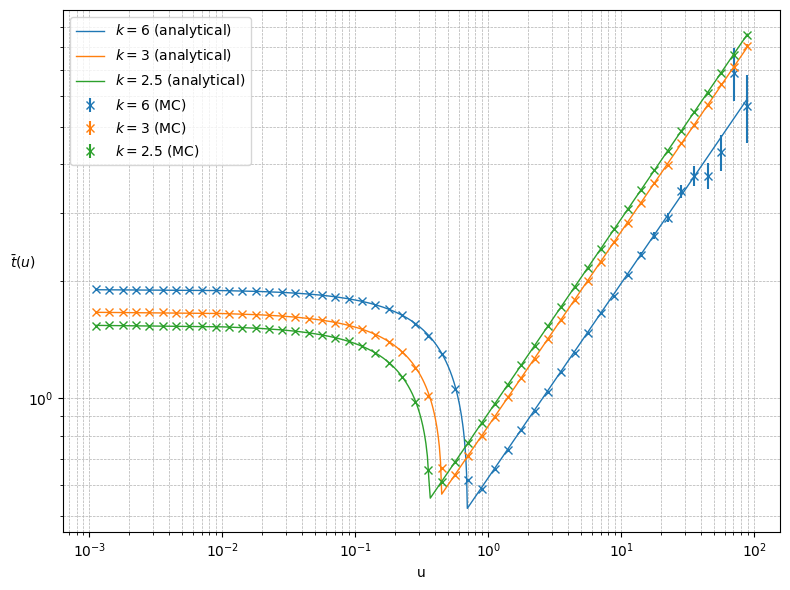

In [7]:
plt.figure(figsize=(8,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c' ]
for i in range(0,3):
    v_range = np.linspace(v_centers[i][0], v_centers[i][-1], 10000)
    p_anal = np.array([
        2.0*float( mp.re(
            (
                (((kas[i] / (kas[i] - 1)) ** (kas[i] + 1)) / (kas[i] + 1)) * v ** ((kas[i] + 2) / 2)
                /
                (
                    (mp.sqrt(mp.pi) * mp.gamma((kas[i] + 2) / 2)) / (2 * mp.gamma((kas[i] + 3) / 2))
                    -
                    (
                        mp.sqrt(((kas[i] - 1) / kas[i]) ** 2 / v - 1)
                        *
                        mp.hyp2f1(0.5, (kas[i] + 3) / 2, 1.5, 1 - (((kas[i] - 1) / kas[i]) ** 2 / v))
                    )
                )
            ) * np.heaviside((1-1/kas[i])**2 - v, 1)
            +
            (
                2 * mp.gamma((kas[i] + 3) / 2)
                /
                ((kas[i] + 1) * mp.sqrt(mp.pi) * mp.gamma((kas[i] + 2) / 2))
                * mp.sqrt(v)
            ) * np.heaviside(v - (1-1/kas[i])**2, 0)
        ))
        for v in v_range
    ])
    plt.plot(v_range, p_anal, '-', color=colors[i], linewidth=1, label=r'$k =' + str(kas[i]) + '$ (analytical)')
    plt.errorbar(v_centers[i], shear_given_v[i], yerr=sh_error_given_v[i], linestyle='', marker='x', markersize=6, color=colors[i], label=r'$k =' + str(kas[i]) + '$ (MC)') 
    

plt.xlabel('u')
plt.ylabel(r'$\bar{t}(u)$', rotation=0)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("shear_vs_vel_pareto.pdf", format='pdf')
plt.show()
